In [1]:
import scripts.display_bixi as dsp_bx
import scripts.compute_bixi as cpt_bx
import pandas as pd
import geopandas as gpd
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import TimestampedGeoJson
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from tqdm import tqdm

In [2]:
def time_str_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m

In [3]:
stations_info_url = "https://gbfs.velobixi.com/gbfs/en/station_information.json"
st = cpt_bx.download_json(stations_info_url)["data"]["stations"]

In [4]:
station_info_df = pd.DataFrame(st)

In [5]:
import psycopg2
import pandas as pd
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

load_dotenv()

def get_pg_engine():
    url = URL.create(
        drivername="postgresql+psycopg2",
        username=os.getenv("user"),
        password=os.getenv("password"),
        host=os.getenv("host"),
        port=os.getenv("port"),
        database=os.getenv("dbname"),
    )
    engine = create_engine(url)
    return engine

engine = get_pg_engine()

def get_24h_stats(engine):
    query = """
    SELECT
        station_id,
        TO_CHAR((timestamp AT TIME ZONE 'UTC' AT TIME ZONE 'America/Montreal'), 'HH24:MI') AS time_15min,
        (num_docks_available::float / (num_docks_available+num_bikes_available)) AS score
    FROM
        bixi_dispo
    WHERE (num_docks_available + num_bikes_available) > 0;;
    """
    return pd.read_sql(query, con=engine)

def get_24h_stats_id(station_id,engine):
    query = f"""
    SELECT
        station_id,
        TO_CHAR((timestamp AT TIME ZONE 'UTC' AT TIME ZONE 'America/Montreal'), 'HH24:MI') AS time_15min,
        (num_docks_available::float / (num_docks_available+num_bikes_available)) AS score
    FROM
        bixi_dispo
    WHERE station_id = '{station_id}' AND (num_docks_available + num_bikes_available) > 0;;
    """
    return pd.read_sql(query, con=engine)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def create_station_chart(station_id,engine,station_info_df):
    df = get_24h_stats_id(station_id,engine)
    bins = np.linspace(0, 1, 11)
    df['score_bin'] = pd.cut(df['score'], bins=bins, include_lowest=True)
    bin_counts = df.groupby(['station_id','time_15min', 'score_bin'],observed=False).size().reset_index(name='count')
    pivot = bin_counts.pivot(index='time_15min', columns='score_bin', values='count').fillna(0)
    time_array = pivot.index.to_numpy()        
    score_bin_arrays = {bin_label: pivot[bin_label].to_numpy() for bin_label in pivot.columns}    
    total_arr = []
    bin_ix = []
    for key in score_bin_arrays.keys():
        total_arr.append(score_bin_arrays[key])
        bin_ix.append(key) 

    stacked = np.vstack(total_arr).astype(float)
    stacked /= stacked.sum(axis=0)

    cmap = plt.cm.seismic 
    colors = [mcolors.to_hex(cmap(i)) for i in np.linspace(0.6, 0.3, bins.shape[0])]

    # Plot
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.stackplot(time_array, stacked, colors=colors, edgecolor='none')
    ax.set_title(station_info_df[station_info_df["station_id"] == station_id]["name"].item(), fontsize=12)
    ax.set_ylim(0, 1)
    tick_interval = 4 * 4  # 2hours
    xticks = time_array[::tick_interval]
    ax.set_xticks(xticks)
    plt.tight_layout()
    plt.show()


In [7]:
BINS = np.linspace(0, 1, 11)
CAMP = plt.cm.seismic
COLORS = [mcolors.to_hex(CAMP(i)) for i in np.linspace(0.6, 0.3, BINS.shape[0])]


def create_station_chart_subplot(ax, station_id, station_df, station_info_df):
    df = station_df.copy()
    df['score_bin'] = pd.cut(df['score'], bins=BINS, include_lowest=True)
    bin_counts = df.groupby(['station_id', 'time_15min', 'score_bin'], observed=False).size().reset_index(name='count')
    all_bins = pd.Categorical(pd.cut([0.0], bins=BINS, include_lowest=True)).categories
    pivot = bin_counts.pivot(index='time_15min', columns='score_bin', values='count')
    pivot = pivot.reindex(columns=all_bins, fill_value=0).fillna(0)

    time_array = pivot.index.to_numpy()
    # Convert interval bin labels to strings to avoid dtype issues
    pivot.columns = pivot.columns.astype(str)
    stacked = pivot.to_numpy().T.astype(float)

    # Normalize safely
    col_sums = stacked.sum(axis=0)
    col_sums[col_sums == 0] = 1  # Avoid divide by zero
    stacked /= col_sums

    # Plot on provided axis
    ax.stackplot(time_array, stacked, colors=COLORS, edgecolor='none')
    station_name = station_info_df[station_info_df["station_id"] == station_id]["name"].item()
    ax.set_title(station_name, fontsize=8)
    ax.set_ylim(0, 1)

    tick_interval = 4 * 4  # 4 hours
    xticks = time_array[::tick_interval]
    ax.set_xticks(xticks)

    # Optional: smaller font size and hide y-axis ticks for compactness
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_yticks([])  # hide y-axis ticks to reduce clutter


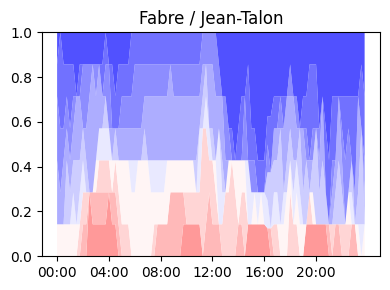

In [8]:
station_id = "131"
create_station_chart(station_id,engine,station_info_df)

In [9]:
import traceback
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from tqdm import tqdm
import matplotlib.pyplot as plt

def do_all(station_info_df, engine):
    df_all = get_24h_stats(engine)
    station_ids = df_all['station_id'].unique().astype(str).tolist()
    plots_per_row = 5
    num_plots = len(station_ids)
    num_rows = (num_plots + plots_per_row - 1) // plots_per_row

    cmap = plt.cm.seismic  # Define your colormap here

    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row*4, num_rows*3), squeeze=False)

    for i, station_id in tqdm(enumerate(station_ids), total=num_plots):
        row = i // plots_per_row
        col = i % plots_per_row
        ax = axes[row, col]
        station_df = df_all[df_all['station_id'] == int(station_id)]
        if len(station_df) == 0:
            continue
        try:
            create_station_chart_subplot(ax, station_id, station_df, station_info_df)
        except Exception as e:
            print(f"Error with station {station_id} at index {i}: {e}")
            traceback.print_exc()

    # Hide unused subplots if any
    for j in range(num_plots, num_rows * plots_per_row):
        fig.delaxes(axes.flatten()[j])

    fig.tight_layout()
    fig.savefig("all_stations.svg", format='svg')
    plt.close(fig)


In [10]:
do_all(station_info_df,engine)

100%|██████████| 967/967 [00:27<00:00, 35.21it/s]


In [11]:
station_info_df[station_info_df["station_id"] == station_id]["name"].item()

'Fabre / Jean-Talon'

In [12]:
df_all = get_24h_stats(engine)

In [13]:
station_ids = df_all['station_id'].unique().astype(str).tolist()

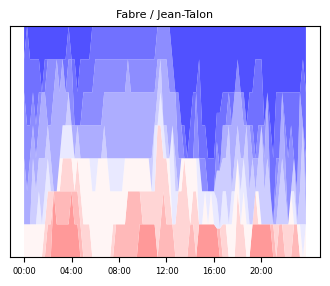

In [14]:
station_ids[3]
fig, axes = plt.subplots(1, 1, figsize=(1*4, 1*3), squeeze=False)
ax = axes[0,0]
station_df = df_all[df_all['station_id'] == int(station_id)]
try : 
    create_station_chart_subplot(ax, station_id,station_df, station_info_df )
except Exception as e:
    print(e)

In [15]:
len(station_df)

674

In [16]:
df_all = get_24h_stats(engine)


In [17]:
station_id = "24"

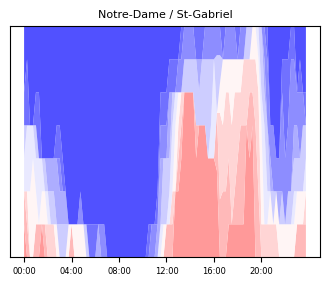

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(1*4, 1*3), squeeze=False)

station_df = df_all[df_all['station_id'] == int(station_id)]
ax = axes[0,0]
create_station_chart_subplot(ax, station_id,station_df,station_info_df )


In [19]:
station_df["score"]

23        0.066667
979       0.133333
1935      0.200000
2891      0.266667
3847      0.200000
            ...   
645501    0.533333
646467    0.466667
647433    0.466667
648399    0.600000
649365    0.600000
Name: score, Length: 674, dtype: float64